# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 756.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open('/content/drive/My Drive/smsspamcollection/SMSSpamCollection'):
    ham_spam = line.split()
    if ham_spam[0] == "ham":
      print("line:", line[3:])
      print("label:", ham_spam[0])
      break
print("\n\n")
for line in open('/content/drive/My Drive/smsspamcollection/SMSSpamCollection'):
    ham_spam = line.split()
    if ham_spam[0] == "spam":
      print("line:", line[4:])
      print("label:", ham_spam[0])
      break

line: 	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

label: ham



line: 	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

label: spam


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
# spam counting
spam_count = 0
nonspam_count = 0
for line in open('/content/drive/My Drive/smsspamcollection/SMSSpamCollection'):
    ham_spam = line.split()
    if ham_spam[0] == "spam":
      spam_count += 1
    else:
      nonspam_count += 1
print("number of spam messages:", spam_count)
print("number of non-spam messages:", nonspam_count)

number of spam messages: 747
number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Answer:**

advantages:
1. The discrete space is significantly smaller with using sequence of characters. There are around 26 English characters. Nonetheless, the amount of words is around thousands of thousands. This suggests that simply keeping the word embeddings will demand a lot of memory, and integrating word embeddings in a model adds numerous parameters to the model. Therefore the computational cost of employing the word level model is substantially greater than the character level model.
2. The model is not flexible when using sequences of words since words that are misspelt or otherwise not in the vocabulary are often handled as a special "unknown" token, but it will be considerably more versatile when using sequences of characters.

disadvantages:
1. Character-level models are capable of creating strange words, including meaningless words.
2. They struggle to adequately model long-distance dependencies. For instance, a character-level RNN must make predictions for the same number of times as the number of characters in order to forecast up to the tenth word from the beginning of a phrase, but a word-level RNN must make predictions for the first nine.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext
#from torchtext import data
#from torchtext import datasets

# define the columns that we want to process and how to process
txt_field = torchtext.legacy.data.Field(sequential=True, 
                       tokenize=lambda x: x, 
                       include_lengths=True, 
                       batch_first=True,
                       use_vocab=True)
label_field = torchtext.legacy.data.Field(sequential=False, 
                         use_vocab=False,
                         is_target=True,      
                         batch_first=True, 
                         pad_token=None, 
                         unk_token=None,
                         preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', txt_field)]

datas = torchtext.legacy.data.TabularDataset(path='/content/drive/My Drive/smsspamcollection/SMSSpamCollection', 
                                            format='tsv',  
                                            fields=fields)

train_data, validation_data, test_data = datas.split(split_ratio=[0.6, 0.2, 0.2])
print("length of train data:", len(train_data))
print("length of validation data:", len(validation_data))
print("length of test data:", len(test_data))

length of train data: 3343
length of validation data: 1115
length of test data: 1114


In [ ]:
train_data[0].label

1

In [ ]:
train_data[0].sms

'Congrats 2 mobile 3G Videophones R yours. call 09063458130 now! videochat wid ur mates, play java games, Dload polypH music, noline rentl. bx420. ip4. 5we. 150p'

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

**Answer:**

Consider a case that we have a dataset and we want to predict if someone has cancer. The number of people that do not have cancer is much more than the ones having cancer and so our intial dataset is very imbalanced. let's say we train our model on this dataset, then the model will see lots of samples of people not having cancer and so will not generalize. The chance that this model predicting most of the people to be healthy is very high and so it may not give correct result about patients having cancer which is very dangerous and can risk their lives. So, feeding model unbalanced data may cause it to be biassed in favour of the majority class since it lacked sufficient information to understand the minority. That's why we should balance our data before feeding it to our model by either upsampling the minority class or downsampling the majority class.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
txt_field.build_vocab(train_data)
print(txt_field.vocab.stoi, "\n")
print(txt_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f35759a2910>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '0': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, 'T': 26, '2': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, 'A': 38, '4': 39, '7': 40, 'x': 41, '6': 42, 'R': 43, '3': 44, '!': 45, 'P': 46, ',': 47, 'W': 48, '9': 49, 'M': 50, 'L': 51, 'U': 52, 'H': 53, 'D': 54, 'G': 55, 'B': 56, 'Y': 57, 'F': 58, "'": 59, '?': 60, '/': 61, '£': 62, '&': 63, '-': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, 'J': 72, ')': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, '\x92': 86, '<': 87, 'Ü': 88, '‘': 89, '$': 90, '_': 91, '|': 92, '¡': 93, '“': 94, '%': 95, '–': 96, '\x93': 97, 'ú': 98,

**Answer:**

text_field.vocab.stoi: A collections.defaultdict instance mapping token strings to numerical identifiers.

text_field.vocab.itos: A list of token strings indexed by their numerical identifiers.

https://torchtext.readthedocs.io/en/latest/vocab.html

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:**

\<unk> : It's for unknown tokens.

\<pad> : It's for padding to make sure SMS test messages have the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 1
for batch in train_iter:
  #print(batch.sms[0][0])
  if i > 10:
    break
  print("Batch", i, ":")
  print("Maximum length of the input sequence:", int(batch.sms[1][0]))
  pad_count = 0
  for j in range(len(batch.sms[1])):
    pad_count += batch.sms[1][0] - batch.sms[1][j]
  print("Count of pad tokens:", int(pad_count))
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)
  print("\n")
  i += 1

Batch 1 :
Maximum length of the input sequence: 59
Count of pad tokens: 59


Batch 2 :
Maximum length of the input sequence: 37
Count of pad tokens: 13


Batch 3 :
Maximum length of the input sequence: 119
Count of pad tokens: 94


Batch 4 :
Maximum length of the input sequence: 144
Count of pad tokens: 20


Batch 5 :
Maximum length of the input sequence: 175
Count of pad tokens: 128


Batch 6 :
Maximum length of the input sequence: 153
Count of pad tokens: 7


Batch 7 :
Maximum length of the input sequence: 154
Count of pad tokens: 0


Batch 8 :
Maximum length of the input sequence: 78
Count of pad tokens: 41


Batch 9 :
Maximum length of the input sequence: 38
Count of pad tokens: 10


Batch 10 :
Maximum length of the input sequence: 142
Count of pad tokens: 18




## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.name = "RNN"
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_loader, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_data_loader = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size,
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)
    valid_data_loader = torchtext.legacy.data.BucketIterator(valid, batch_size=batch_size, 
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)
    for epoch in range(num_epochs):

        for tweets, labels in train_data_loader:
            optimizer.zero_grad()
            pred = model(tweets[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for tweets, labels in valid_data_loader:
            pred = model(tweets[0])
            loss2 = criterion(pred, labels)
        valid_losses.append(float(loss2))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_data_loader, batch_size))
        valid_acc.append(get_accuracy(model, valid_data_loader, batch_size))
        print("Epoch %d; train_Loss %f; valid_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, loss2, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; train_Loss 0.661593; valid_Loss 0.668605; Train Acc 0.708340; Val Acc 0.809865
Epoch 2; train_Loss 0.374909; valid_Loss 0.499177; Train Acc 0.894200; Val Acc 0.922870
Epoch 3; train_Loss 0.408669; valid_Loss 0.362804; Train Acc 0.915093; Val Acc 0.949776
Epoch 4; train_Loss 0.557504; valid_Loss 0.244034; Train Acc 0.921277; Val Acc 0.954260
Epoch 5; train_Loss 0.036332; valid_Loss 0.143283; Train Acc 0.921277; Val Acc 0.943498
Epoch 6; train_Loss 0.089854; valid_Loss 0.135403; Train Acc 0.930470; Val Acc 0.955157
Epoch 7; train_Loss 0.667269; valid_Loss 0.682212; Train Acc 0.923951; Val Acc 0.913004
Epoch 8; train_Loss 0.112357; valid_Loss 0.192318; Train Acc 0.932977; Val Acc 0.953363
Epoch 9; train_Loss 0.044121; valid_Loss 0.193375; Train Acc 0.923283; Val Acc 0.922870
Epoch 10; train_Loss 0.720952; valid_Loss 0.269999; Train Acc 0.813639; Val Acc 0.900448
Epoch 11; train_Loss 0.487728; valid_Loss 0.199973; Train Acc 0.933144; Val Acc 0.948879
Epoch 12; train_Loss 0.449832;

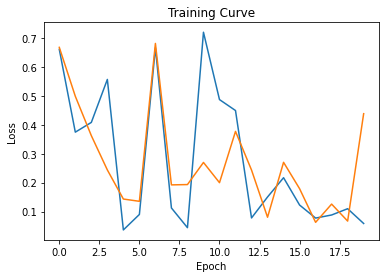

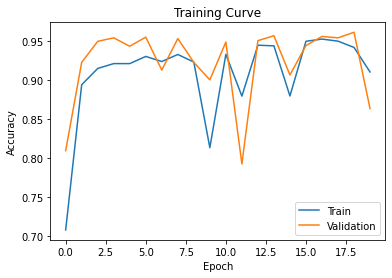

In [ ]:
model = RNN(len(txt_field.vocab), 100, 2)
train_rnn_network(model, train_data, validation_data, batch_size=64, num_epochs=20, learning_rate=2e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; train_Loss 0.549630; valid_Loss 0.420635; Train Acc 0.752465; Val Acc 0.868161
Epoch 2; train_Loss 0.248792; valid_Loss 0.137690; Train Acc 0.891359; Val Acc 0.911211
Epoch 3; train_Loss 0.512576; valid_Loss 0.401163; Train Acc 0.899382; Val Acc 0.900448
Epoch 4; train_Loss 0.333284; valid_Loss 0.207232; Train Acc 0.916597; Val Acc 0.907623
Epoch 5; train_Loss 0.658714; valid_Loss 0.594726; Train Acc 0.623433; Val Acc 0.773991
Epoch 6; train_Loss 0.302205; valid_Loss 0.300851; Train Acc 0.793080; Val Acc 0.860987
Epoch 7; train_Loss 0.446160; valid_Loss 0.435472; Train Acc 0.934314; Val Acc 0.940807
Epoch 8; train_Loss 0.099907; valid_Loss 0.100547; Train Acc 0.908741; Val Acc 0.929148
Epoch 9; train_Loss 0.354093; valid_Loss 0.285428; Train Acc 0.792245; Val Acc 0.890583
Epoch 10; train_Loss 0.558598; valid_Loss 0.238018; Train Acc 0.843557; Val Acc 0.864574
Epoch 11; train_Loss 0.362853; valid_Loss 0.174975; Train Acc 0.890523; Val Acc 0.894170
Epoch 12; train_Loss 0.436092;

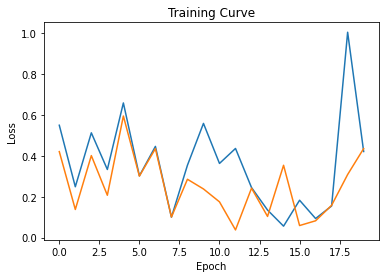

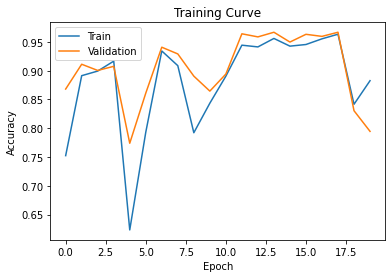




Epoch 1; train_Loss 0.596852; valid_Loss 0.767773; Train Acc 0.534682; Val Acc 0.142601
Epoch 2; train_Loss 0.642050; valid_Loss 0.724805; Train Acc 0.540197; Val Acc 0.147982
Epoch 3; train_Loss 0.659981; valid_Loss 0.692132; Train Acc 0.693632; Val Acc 0.711211
Epoch 4; train_Loss 0.596860; valid_Loss 0.637971; Train Acc 0.744108; Val Acc 0.811659
Epoch 5; train_Loss 0.591349; valid_Loss 0.419479; Train Acc 0.782216; Val Acc 0.889686
Epoch 6; train_Loss 0.265847; valid_Loss 0.243414; Train Acc 0.887515; Val Acc 0.903139
Epoch 7; train_Loss 0.618287; valid_Loss 0.309714; Train Acc 0.837874; Val Acc 0.765919
Epoch 8; train_Loss 0.231189; valid_Loss 0.265387; Train Acc 0.920608; Val Acc 0.915695
Epoch 9; train_Loss 0.065584; valid_Loss 0.483831; Train Acc 0.836370; Val Acc 0.732735
Epoch 10; train_Loss 0.557938; valid_Loss 0.227127; Train Acc 0.933645; Val Acc 0.930045
Epoch 11; train_Loss 0.294672; valid_Loss 0.332758; Train Acc 0.914257; Val Acc 0.883408
Epoch 12; train_Loss 0.5165

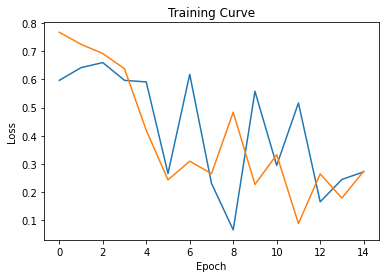

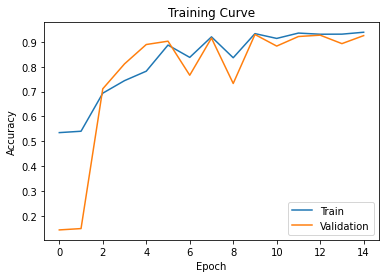




Epoch 1; train_Loss 0.891060; valid_Loss 0.739922; Train Acc 0.489554; Val Acc 0.434081
Epoch 2; train_Loss 0.757362; valid_Loss 0.705403; Train Acc 0.488384; Val Acc 0.469955
Epoch 3; train_Loss 0.894997; valid_Loss 0.650617; Train Acc 0.492562; Val Acc 0.469955
Epoch 4; train_Loss 0.521083; valid_Loss 0.508255; Train Acc 0.656861; Val Acc 0.730942
Epoch 5; train_Loss 0.605956; valid_Loss 0.514767; Train Acc 0.615243; Val Acc 0.818834
Epoch 6; train_Loss 0.128981; valid_Loss 0.184146; Train Acc 0.929634; Val Acc 0.948879
Epoch 7; train_Loss 0.584507; valid_Loss 0.287036; Train Acc 0.908574; Val Acc 0.911211
Epoch 8; train_Loss 0.043178; valid_Loss 0.077576; Train Acc 0.818987; Val Acc 0.932735
Epoch 9; train_Loss 0.781131; valid_Loss 0.198763; Train Acc 0.911416; Val Acc 0.949776
Epoch 10; train_Loss 0.697322; valid_Loss 0.093639; Train Acc 0.907739; Val Acc 0.936323
Epoch 11; train_Loss 0.588968; valid_Loss 0.132522; Train Acc 0.902223; Val Acc 0.940807
Epoch 12; train_Loss 2.6084

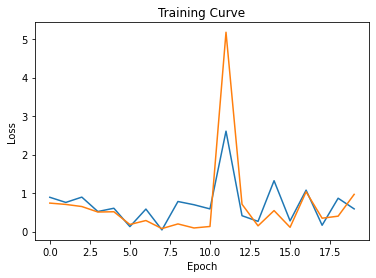

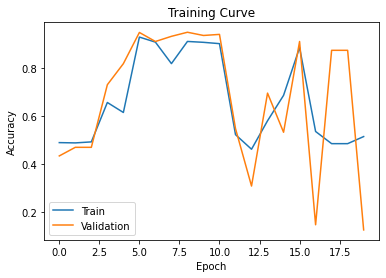




Epoch 1; train_Loss 0.633877; valid_Loss 0.615167; Train Acc 0.759819; Val Acc 0.837668
Epoch 2; train_Loss 0.269111; valid_Loss 0.237216; Train Acc 0.904229; Val Acc 0.917489
Epoch 3; train_Loss 0.455184; valid_Loss 0.307193; Train Acc 0.920608; Val Acc 0.943498
Epoch 4; train_Loss 0.414326; valid_Loss 0.299521; Train Acc 0.920441; Val Acc 0.915695
Epoch 5; train_Loss 0.065344; valid_Loss 0.143552; Train Acc 0.922781; Val Acc 0.914798
Epoch 6; train_Loss 0.117402; valid_Loss 0.153795; Train Acc 0.929634; Val Acc 0.947085
Epoch 7; train_Loss 0.535161; valid_Loss 0.266229; Train Acc 0.933144; Val Acc 0.950673
Epoch 8; train_Loss 0.100050; valid_Loss 0.171234; Train Acc 0.932475; Val Acc 0.951570
Epoch 9; train_Loss 0.020625; valid_Loss 0.140819; Train Acc 0.928130; Val Acc 0.935426
Epoch 10; train_Loss 0.661181; valid_Loss 0.573186; Train Acc 0.744610; Val Acc 0.797309


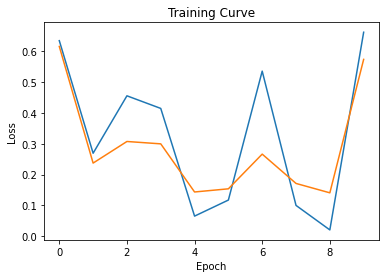

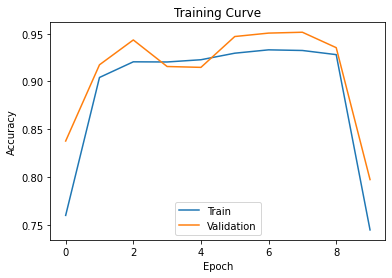




Epoch 1; train_Loss 0.549017; valid_Loss 0.526055; Train Acc 0.821829; Val Acc 0.868161
Epoch 2; train_Loss 0.242591; valid_Loss 0.284685; Train Acc 0.895704; Val Acc 0.895964
Epoch 3; train_Loss 0.444175; valid_Loss 0.285229; Train Acc 0.924954; Val Acc 0.943498
Epoch 4; train_Loss 0.469374; valid_Loss 0.247232; Train Acc 0.934147; Val Acc 0.941704
Epoch 5; train_Loss 0.076791; valid_Loss 0.163590; Train Acc 0.930135; Val Acc 0.956951
Epoch 6; train_Loss 0.371977; valid_Loss 0.419074; Train Acc 0.819990; Val Acc 0.845740
Epoch 7; train_Loss 0.464189; valid_Loss 0.405955; Train Acc 0.874812; Val Acc 0.871749
Epoch 8; train_Loss 0.106605; valid_Loss 0.109730; Train Acc 0.875648; Val Acc 0.916592
Epoch 9; train_Loss 1.610567; valid_Loss 0.349011; Train Acc 0.596189; Val Acc 0.903139
Epoch 10; train_Loss 0.642950; valid_Loss 0.223552; Train Acc 0.799933; Val Acc 0.893274
Epoch 11; train_Loss 0.302494; valid_Loss 0.206316; Train Acc 0.930470; Val Acc 0.967713
Epoch 12; train_Loss 0.8460

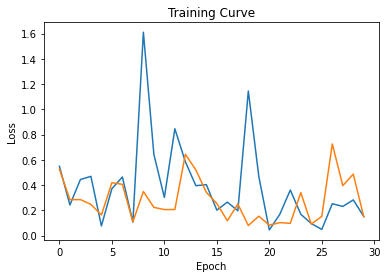

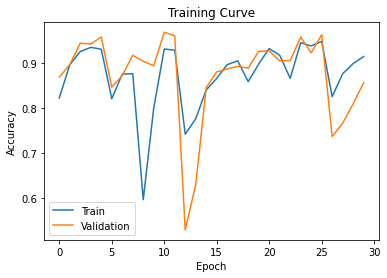




Epoch 1; train_Loss 0.428988; valid_Loss 0.406804; Train Acc 0.842387; Val Acc 0.849327
Epoch 2; train_Loss 0.266884; valid_Loss 0.304751; Train Acc 0.846231; Val Acc 0.869058
Epoch 3; train_Loss 0.641400; valid_Loss 0.663944; Train Acc 0.560755; Val Acc 0.522870
Epoch 4; train_Loss 1.682345; valid_Loss 1.603366; Train Acc 0.464984; Val Acc 0.475336
Epoch 5; train_Loss 0.420561; valid_Loss 0.818581; Train Acc 0.550894; Val Acc 0.523767
Epoch 6; train_Loss 0.381101; valid_Loss 0.733575; Train Acc 0.704162; Val Acc 0.677130
Epoch 7; train_Loss 0.721189; valid_Loss 0.800194; Train Acc 0.541367; Val Acc 0.299552
Epoch 8; train_Loss 0.434424; valid_Loss 0.147626; Train Acc 0.870801; Val Acc 0.897758
Epoch 9; train_Loss 1.970221; valid_Loss 0.408882; Train Acc 0.470834; Val Acc 0.447534
Epoch 10; train_Loss 0.736816; valid_Loss 0.491529; Train Acc 0.749791; Val Acc 0.860987
Epoch 11; train_Loss 0.444967; valid_Loss 0.532223; Train Acc 0.572957; Val Acc 0.504036
Epoch 12; train_Loss 1.4585

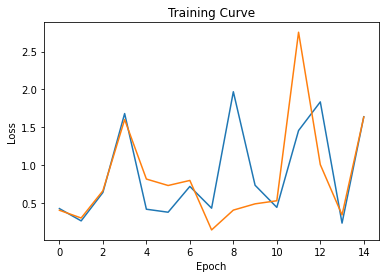

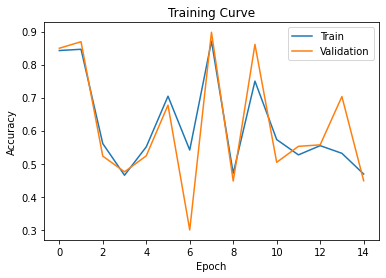

In [ ]:
# learning rate, epoch, number of hidden units, rrn model itself
learning_rate_list = [0.001, 0.0001, 0.005, 0.0005, 0.001, 0.005]
epoch_list = [20, 15, 20, 10, 30, 15]
no_hidden_unit_list = [100, 50, 150, 50, 50, 100]
for i in range(len(learning_rate_list)):
  model = RNN(len(txt_field.vocab), no_hidden_unit_list[i], 2)
  train_rnn_network(model, train_data, validation_data, batch_size=64, num_epochs=epoch_list[i], learning_rate=learning_rate_list[i])
  print("\n\n")

In [ ]:
# tunning rnn model

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN2, self).__init__()
        self.name = "RNN2"
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #out = torch.cat([torch.max(out, dim=1)[0], 
        #                 torch.mean(out, dim=1)], dim=1)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_data_loader = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size,
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)
    valid_data_loader = torchtext.legacy.data.BucketIterator(valid, batch_size=batch_size, 
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)
    for epoch in range(num_epochs):

        for tweets, labels in train_data_loader:
            optimizer.zero_grad()
            pred = model(tweets[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for tweets, labels in valid_data_loader:
            pred = model(tweets[0])
            loss2 = criterion(pred, labels)
        valid_losses.append(float(loss2))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_data_loader, batch_size))
        valid_acc.append(get_accuracy(model, valid_data_loader, batch_size))
        print("Epoch %d; train_Loss %f; valid_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, loss2, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; train_Loss 0.176098; valid_Loss 0.260336; Train Acc 0.948019; Val Acc 0.974888
Epoch 2; train_Loss 0.210079; valid_Loss 0.125882; Train Acc 0.953201; Val Acc 0.973991
Epoch 3; train_Loss 0.159955; valid_Loss 0.231699; Train Acc 0.954371; Val Acc 0.973991
Epoch 4; train_Loss 0.169800; valid_Loss 0.108863; Train Acc 0.961391; Val Acc 0.953363
Epoch 5; train_Loss 0.016328; valid_Loss 0.089718; Train Acc 0.966405; Val Acc 0.973094
Epoch 6; train_Loss 0.026390; valid_Loss 0.041696; Train Acc 0.974093; Val Acc 0.969507
Epoch 7; train_Loss 0.491957; valid_Loss 0.326286; Train Acc 0.967909; Val Acc 0.955157
Epoch 8; train_Loss 0.033956; valid_Loss 0.030100; Train Acc 0.979107; Val Acc 0.981166
Epoch 9; train_Loss 0.030968; valid_Loss 0.065446; Train Acc 0.986127; Val Acc 0.980269
Epoch 10; train_Loss 0.212893; valid_Loss 0.055760; Train Acc 0.977269; Val Acc 0.976682
Epoch 11; train_Loss 0.084555; valid_Loss 0.015658; Train Acc 0.986963; Val Acc 0.977578
Epoch 12; train_Loss 0.150971;

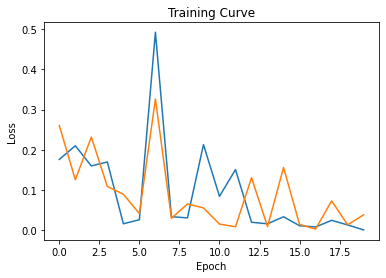

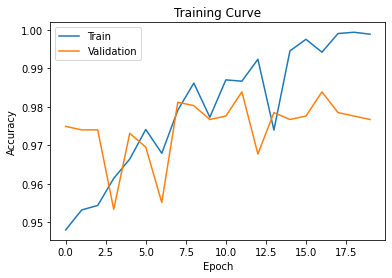




Epoch 1; train_Loss 0.831060; valid_Loss 0.549700; Train Acc 0.485208; Val Acc 0.874439
Epoch 2; train_Loss 0.743402; valid_Loss 0.599309; Train Acc 0.485208; Val Acc 0.874439
Epoch 3; train_Loss 0.679029; valid_Loss 0.660709; Train Acc 0.791576; Val Acc 0.938117
Epoch 4; train_Loss 0.659090; valid_Loss 0.637644; Train Acc 0.937657; Val Acc 0.965022
Epoch 5; train_Loss 0.597824; valid_Loss 0.643879; Train Acc 0.945345; Val Acc 0.955157
Epoch 6; train_Loss 0.604402; valid_Loss 0.607501; Train Acc 0.938827; Val Acc 0.948879
Epoch 7; train_Loss 0.551025; valid_Loss 0.486140; Train Acc 0.912419; Val Acc 0.955157
Epoch 8; train_Loss 0.471432; valid_Loss 0.484895; Train Acc 0.941668; Val Acc 0.940807
Epoch 9; train_Loss 0.227529; valid_Loss 0.385449; Train Acc 0.940999; Val Acc 0.913004
Epoch 10; train_Loss 0.476740; valid_Loss 0.363888; Train Acc 0.926458; Val Acc 0.959641
Epoch 11; train_Loss 0.261250; valid_Loss 0.394642; Train Acc 0.932475; Val Acc 0.890583
Epoch 12; train_Loss 0.3415

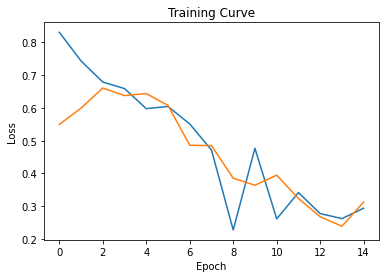

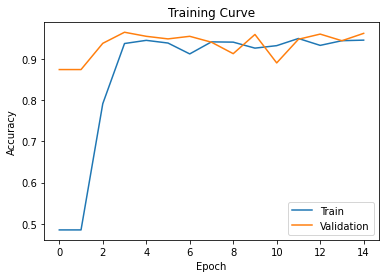




Epoch 1; train_Loss 0.716521; valid_Loss 0.703482; Train Acc 0.721043; Val Acc 0.499552
Epoch 2; train_Loss 0.299638; valid_Loss 0.069277; Train Acc 0.932475; Val Acc 0.967713
Epoch 3; train_Loss 0.396733; valid_Loss 0.233486; Train Acc 0.929300; Val Acc 0.968610
Epoch 4; train_Loss 0.213100; valid_Loss 0.150627; Train Acc 0.947351; Val Acc 0.922870
Epoch 5; train_Loss 0.014779; valid_Loss 0.127573; Train Acc 0.963731; Val Acc 0.968610
Epoch 6; train_Loss 0.093935; valid_Loss 0.169163; Train Acc 0.946181; Val Acc 0.904933
Epoch 7; train_Loss 0.445337; valid_Loss 0.305521; Train Acc 0.966906; Val Acc 0.949776
Epoch 8; train_Loss 0.067488; valid_Loss 0.052255; Train Acc 0.971085; Val Acc 0.957848
Epoch 9; train_Loss 0.046204; valid_Loss 0.096677; Train Acc 0.970249; Val Acc 0.983857
Epoch 10; train_Loss 0.285800; valid_Loss 0.030040; Train Acc 0.960555; Val Acc 0.972197
Epoch 11; train_Loss 0.354113; valid_Loss 0.015696; Train Acc 0.961391; Val Acc 0.978475
Epoch 12; train_Loss 0.3495

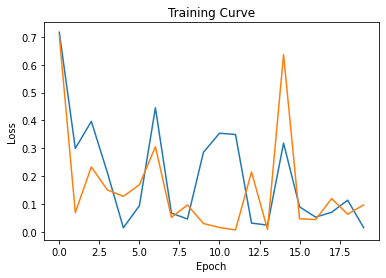

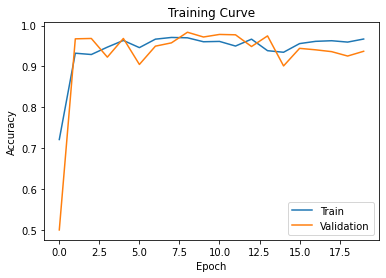




Epoch 1; train_Loss 0.596875; valid_Loss 0.679587; Train Acc 0.820993; Val Acc 0.768610
Epoch 2; train_Loss 0.314931; valid_Loss 0.437292; Train Acc 0.914090; Val Acc 0.962332
Epoch 3; train_Loss 0.351766; valid_Loss 0.285086; Train Acc 0.932141; Val Acc 0.969507
Epoch 4; train_Loss 0.149049; valid_Loss 0.300884; Train Acc 0.941501; Val Acc 0.916592
Epoch 5; train_Loss 0.054152; valid_Loss 0.228016; Train Acc 0.957379; Val Acc 0.961435
Epoch 6; train_Loss 0.093148; valid_Loss 0.141294; Train Acc 0.962895; Val Acc 0.964126
Epoch 7; train_Loss 0.462434; valid_Loss 0.507208; Train Acc 0.948688; Val Acc 0.931839
Epoch 8; train_Loss 0.075254; valid_Loss 0.073796; Train Acc 0.963062; Val Acc 0.970404
Epoch 9; train_Loss 0.036512; valid_Loss 0.134482; Train Acc 0.966238; Val Acc 0.969507
Epoch 10; train_Loss 0.363368; valid_Loss 0.080900; Train Acc 0.968578; Val Acc 0.973094


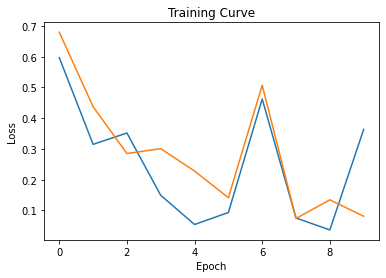

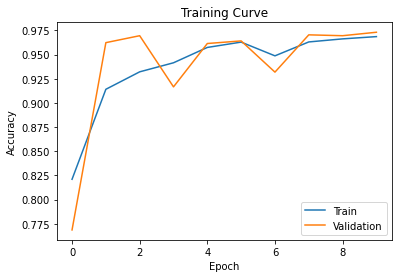




Epoch 1; train_Loss 0.357535; valid_Loss 0.455072; Train Acc 0.941167; Val Acc 0.975785
Epoch 2; train_Loss 0.256541; valid_Loss 0.135690; Train Acc 0.948688; Val Acc 0.974888
Epoch 3; train_Loss 0.335599; valid_Loss 0.236907; Train Acc 0.948521; Val Acc 0.975785
Epoch 4; train_Loss 0.145424; valid_Loss 0.091891; Train Acc 0.958716; Val Acc 0.966816
Epoch 5; train_Loss 0.020803; valid_Loss 0.181280; Train Acc 0.964065; Val Acc 0.969507
Epoch 6; train_Loss 0.040996; valid_Loss 0.074056; Train Acc 0.969413; Val Acc 0.968610
Epoch 7; train_Loss 0.345228; valid_Loss 0.151595; Train Acc 0.970416; Val Acc 0.977578
Epoch 8; train_Loss 0.058375; valid_Loss 0.045781; Train Acc 0.974595; Val Acc 0.967713
Epoch 9; train_Loss 0.035423; valid_Loss 0.135061; Train Acc 0.977269; Val Acc 0.976682
Epoch 10; train_Loss 0.252781; valid_Loss 0.038583; Train Acc 0.977269; Val Acc 0.974888
Epoch 11; train_Loss 0.055690; valid_Loss 0.032842; Train Acc 0.981113; Val Acc 0.976682
Epoch 12; train_Loss 0.2458

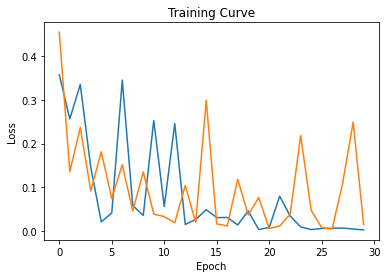

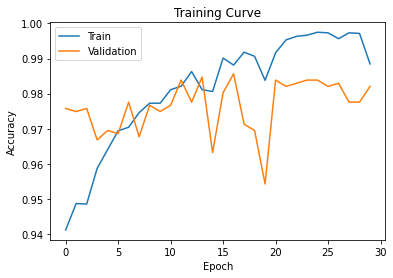




Epoch 1; train_Loss 0.210017; valid_Loss 0.106383; Train Acc 0.944008; Val Acc 0.971300
Epoch 2; train_Loss 0.213734; valid_Loss 0.113446; Train Acc 0.946682; Val Acc 0.967713
Epoch 3; train_Loss 0.357296; valid_Loss 0.244569; Train Acc 0.934648; Val Acc 0.974888
Epoch 4; train_Loss 0.159049; valid_Loss 0.218364; Train Acc 0.946515; Val Acc 0.913901
Epoch 5; train_Loss 0.015777; valid_Loss 0.145112; Train Acc 0.951696; Val Acc 0.973094
Epoch 6; train_Loss 0.069984; valid_Loss 0.157536; Train Acc 0.945847; Val Acc 0.912108
Epoch 7; train_Loss 0.384350; valid_Loss 0.496939; Train Acc 0.954036; Val Acc 0.917489
Epoch 8; train_Loss 0.014876; valid_Loss 0.010710; Train Acc 0.959886; Val Acc 0.974888
Epoch 9; train_Loss 0.013046; valid_Loss 0.117601; Train Acc 0.965402; Val Acc 0.974888
Epoch 10; train_Loss 0.218666; valid_Loss 0.064889; Train Acc 0.954204; Val Acc 0.968610
Epoch 11; train_Loss 0.746824; valid_Loss 0.006618; Train Acc 0.952365; Val Acc 0.978475
Epoch 12; train_Loss 0.3736

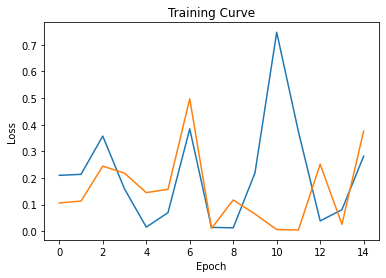

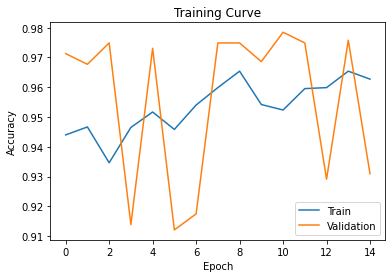

In [ ]:
# learning rate, epoch, number of hidden units, rrn model itself
learning_rate_list = [0.001, 0.0001, 0.005, 0.0005, 0.001, 0.005]
epoch_list = [20, 15, 20, 10, 30, 15]
no_hidden_unit_list = [100, 50, 150, 50, 50, 100]
for i in range(len(learning_rate_list)):
  model = RNN2(len(txt_field.vocab), no_hidden_unit_list[i], 2)
  train_rnn_network(model, train_data, validation_data, batch_size=64, num_epochs=epoch_list[i], learning_rate=learning_rate_list[i])
  print("\n\n")

**My best model:**

**learning rate = 0.001, epoch = 30, number of hidden units = 50, rrn model itself = RNN2**

It has highest validation accuracy around 98%.

Epoch 1; train_Loss 0.367246; valid_Loss 0.510931; Train Acc 0.945345; Val Acc 0.949776
Epoch 2; train_Loss 0.192511; valid_Loss 0.251695; Train Acc 0.943005; Val Acc 0.936323
Epoch 3; train_Loss 0.161741; valid_Loss 0.239002; Train Acc 0.948019; Val Acc 0.968610
Epoch 4; train_Loss 0.114643; valid_Loss 0.171904; Train Acc 0.953368; Val Acc 0.953363
Epoch 5; train_Loss 0.017025; valid_Loss 0.135543; Train Acc 0.961892; Val Acc 0.967713
Epoch 6; train_Loss 0.036227; valid_Loss 0.046872; Train Acc 0.968410; Val Acc 0.968610
Epoch 7; train_Loss 0.578003; valid_Loss 0.477323; Train Acc 0.959886; Val Acc 0.950673
Epoch 8; train_Loss 0.047888; valid_Loss 0.047052; Train Acc 0.966572; Val Acc 0.965919
Epoch 9; train_Loss 0.027848; valid_Loss 0.127017; Train Acc 0.970416; Val Acc 0.968610
Epoch 10; train_Loss 0.251435; valid_Loss 0.063402; Train Acc 0.969413; Val Acc 0.975785
Epoch 11; train_Loss 0.202056; valid_Loss 0.024699; Train Acc 0.976266; Val Acc 0.973991
Epoch 12; train_Loss 0.272191;

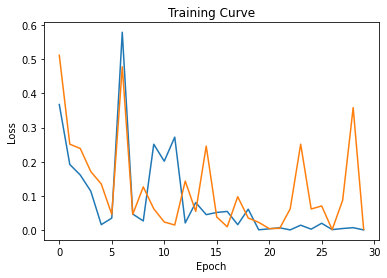

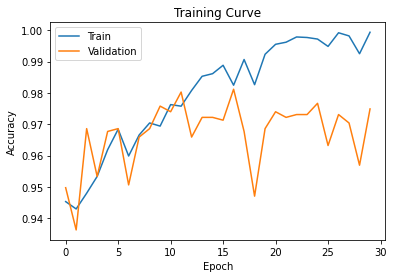

In [ ]:
best_model = RNN2(len(txt_field.vocab), 50, 2)
train_rnn_network(best_model, train_data, validation_data, batch_size=64, num_epochs=30, learning_rate=0.001)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in validation_data.examples if e.label == 1],
    validation_data.fields)
# Create a Dataset of only non-spam validation examples
#valid_nospam = None # TODO
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in validation_data.examples if e.label == 0],
    validation_data.fields)

valid_spam_loader = torchtext.legacy.data.BucketIterator(valid_spam, batch_size=64,
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)
valid_nospam_loader = torchtext.legacy.data.BucketIterator(valid_nospam, batch_size=64, 
                                                             sort_key=lambda x: len(x.sms), sort_within_batch=True)

false_negative_rate = (1 - get_accuracy(best_model, valid_spam_loader, 64)) * 100
false_positive_rate = (1 - get_accuracy(best_model, valid_nospam_loader, 64)) * 100
print("The model's false negative rate is: ", false_negative_rate, "%")
print("The model's false positive rate is: ", false_positive_rate, "%")

The model's false negative rate is:  9.285714285714286 %
The model's false positive rate is:  1.538461538461533 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**

with false positive, user would get messages that are classified as non-spam but they are spam and so user may open this message that is spam and click on a link in that message and get hacked!
with false negative, user is not in danger as messages that are classified as spam are non-spam and so user will not get hacked for example, but they can miss messages that are important to them!

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_loader = torchtext.legacy.data.BucketIterator(test_data, batch_size=64, 
                                                   sort_key=lambda x: len(x.sms), sort_within_batch=True)

test_acc = (get_accuracy(best_model, test_loader, 64)) * 100
print("The model's test accuracy is: ", test_acc, "%")

The model's test accuracy is:  98.38420107719928 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    test_data.fields)
# Create a Dataset of only non-spam validation examples
#valid_nospam = None # TODO
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    test_data.fields)

test_spam_loader = torchtext.legacy.data.BucketIterator(test_spam, batch_size=64,
                                                        sort_key=lambda x: len(x.sms), sort_within_batch=True)
test_nospam_loader = torchtext.legacy.data.BucketIterator(test_nospam, batch_size=64, 
                                                          sort_key=lambda x: len(x.sms), sort_within_batch=True)

false_negative_rate = (1 - get_accuracy(best_model, test_spam_loader, 64)) * 100
false_positive_rate = (1 - get_accuracy(best_model, test_nospam_loader, 64)) * 100
print("The model's false negative rate is: ", false_negative_rate, "%")
print("The model's false positive rate is: ", false_positive_rate, "%")

The model's false negative rate is:  6.586826347305386 %
The model's false positive rate is:  0.6335797254487852 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
helper_list = []
for each_msg in msg:
  helper_list.append(txt_field.vocab.stoi[each_msg])
print(helper_list)

[18, 6, 17, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 17, 4, 4, 11, 45]


In [ ]:
print("the probability that the SMS message 'machine learning is sooo cool!' is spam is:", float(F.softmax(best_model(torch.LongTensor([helper_list])), dim=1)[0][0] * 100), "%")

the probability that the SMS message 'machine learning is sooo cool!' is spam is: 5.164315700531006 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**